##Team 8

Question 1: When considering age gaps and release year with textual features from movie titles and actor pairings, do more distinct and interpretable relationship representation profiles emerge, or do most films still conform to a single dominant portrayal pattern?

Team member: Tiffany (Yu-Ting) Chen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-14/age_gaps.csv"
age_gaps = pd.read_csv(url)

age_gaps.columns = age_gaps.columns.str.lower()

# parse dates
date_cols = [c for c in age_gaps.columns if "birthdate" in c]
for c in date_cols:
    age_gaps[c] = pd.to_datetime(age_gaps[c], errors="coerce")

age_gaps.info()
age_gaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_name          1155 non-null   object        
 1   release_year        1155 non-null   int64         
 2   director            1155 non-null   object        
 3   age_difference      1155 non-null   int64         
 4   couple_number       1155 non-null   int64         
 5   actor_1_name        1155 non-null   object        
 6   actor_2_name        1155 non-null   object        
 7   character_1_gender  1155 non-null   object        
 8   character_2_gender  1155 non-null   object        
 9   actor_1_birthdate   1155 non-null   datetime64[ns]
 10  actor_2_birthdate   1155 non-null   datetime64[ns]
 11  actor_1_age         1155 non-null   int64         
 12  actor_2_age         1155 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(6)
memory

,movie_name,release_year,director,age_difference,couple_number,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_birthdate,actor_2_birthdate,actor_1_age,actor_2_age
0,Harold and Maude,1971,Hal Ashby,52,1,Ruth Gordon,Bud Cort,woman,man,1896-10-30,1948-03-29,75,23
1,Venus,2006,Roger Michell,50,1,Peter O'Toole,Jodie Whittaker,man,woman,1932-08-02,1982-06-03,74,24
2,The Quiet American,2002,Phillip Noyce,49,1,Michael Caine,Do Thi Hai Yen,man,woman,1933-03-14,1982-10-01,69,20
3,The Big Lebowski,1998,Joel Coen,45,1,David Huddleston,Tara Reid,man,woman,1930-09-17,1975-11-08,68,23
4,Beginners,2010,Mike Mills,43,1,Christopher Plummer,Goran Visnjic,man,man,1929-12-13,1972-09-09,81,38


###Feature Engineering & Extended EDA

In [2]:
#title length

age_gaps["title_word_len"] = age_gaps["movie_name"].astype(str).str.split().str.len()
age_gaps["title_word_len"] = age_gaps["movie_name"].astype(str).str.len()

In [3]:
#actor frequency
actors = pd.concat([age_gaps["actor_1_name"], age_gaps["actor_2_name"]]).dropna()
actor_counts = actors.value_counts()

age_gaps["actor_1_freq"] = age_gaps["actor_1_name"].map(actor_counts).fillna(0)
age_gaps["actor_2_freq"] = age_gaps["actor_2_name"].map(actor_counts).fillna(0)

age_gaps["actor_freq_sum"] = age_gaps["actor_1_freq"] + age_gaps["actor_2_freq"]

In [4]:
#director frequency
director_col = "director"
director_counts = age_gaps[director_col].value_counts()
age_gaps["director_freq"] = age_gaps[director_col].map(director_counts).fillna(0)

In [5]:
#select features for clustering

feature_cols = [
    "release_year",
    "age_difference",
    "actor_1_age",
    "actor_2_age",
    "title_word_len",
    "actor_freq_sum",
    "director_freq"
]

X = age_gaps[feature_cols].copy()

X = X.dropna()

In [6]:
age_gap_model = age_gaps.loc[X.index].copy()

In [7]:
#standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##Clustering

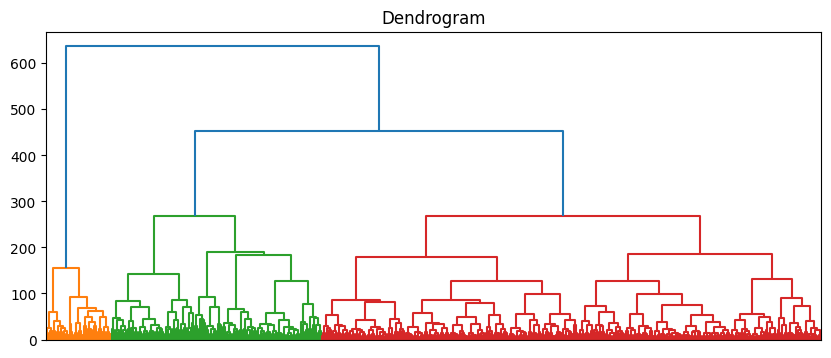

In [8]:
#Hierarchical clustering

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X, method="ward")

#make dendrogram
plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True)
plt.title("Dendrogram")
plt.show()

In [9]:
#dendrogram --> k clusters

from scipy.cluster.hierarchy import fcluster

n_clusters = 5
labels_h = fcluster(linkage(X, method="ward"), n_clusters, criterion="maxclust")

age_gap_model["cluster_hier"] = labels_h.astype(str)
age_gap_model["cluster_hier"].value_counts()

,count
cluster_hier,
4,382
5,362
3,190
2,124
1,97


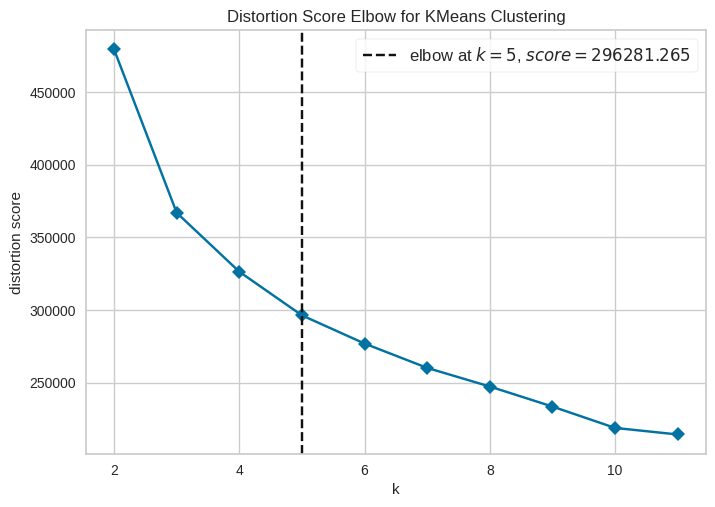

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
#find elbow (distortion)

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42, n_init="auto")
vizualization = KElbowVisualizer(model, k=(2,12), metric="distortion", timings=False)
vizualization.fit(X)
vizualization.show()

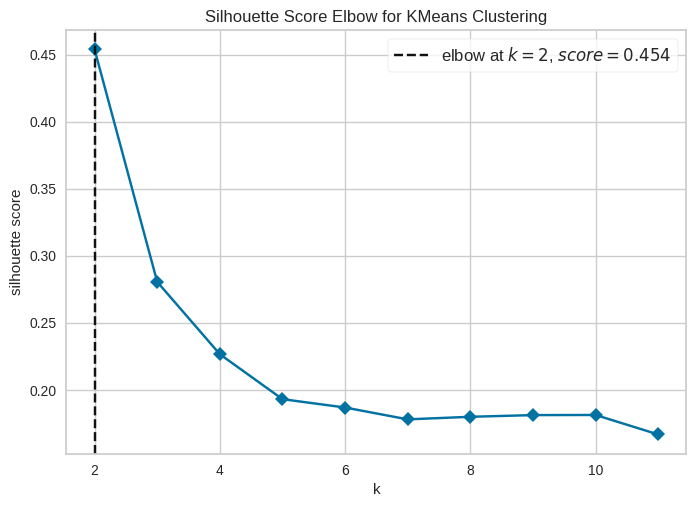

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
#find elbow (silhouette)

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42, n_init="auto")
vizualization = KElbowVisualizer(model, k=(2,12), metric="silhouette", timings=False)
vizualization.fit(X)
vizualization.show()

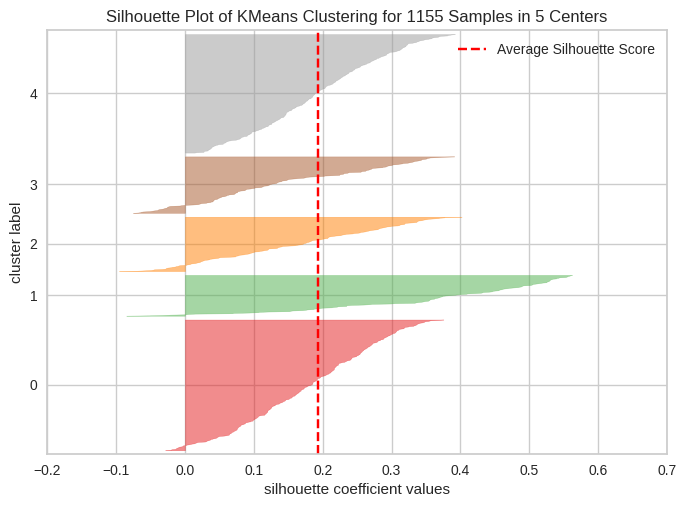

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
#plot silhouette

from yellowbrick.cluster import SilhouetteVisualizer

k=5
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
visualize = SilhouetteVisualizer(km, timings=False)
visualize.fit(X)
visualize.show()

In [13]:
#fit + assign kmeans

k=5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
age_gap_model["cluster_km"] = kmeans.fit_predict(X)

age_gap_model["cluster_km"].value_counts()

,count
cluster_km,
0,376
4,341
3,163
2,157
1,118


/tmp/ipython-input-1025635032.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


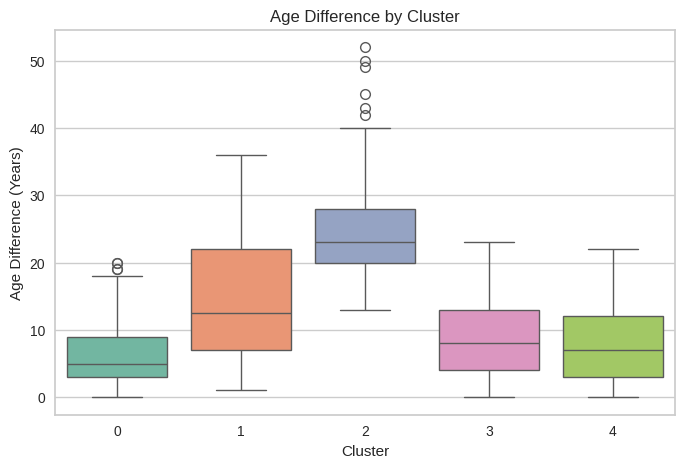

In [14]:
#boxplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=age_gap_model,
    x="cluster_km",
    y="age_difference",
    palette="Set2"
)
plt.title("Age Difference by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age Difference (Years)")
plt.show();

In [15]:
cols_show = ["movie_name","release_year","age_difference","actor_1_name","actor_2_name",director_col,"cluster_km"]
for c in sorted(age_gap_model["cluster_km"].unique()):
    print("\nCLUSTER", c)
    display(age_gap_model[age_gap_model["cluster_km"] == c][cols_show].head(8))


CLUSTER 0


,movie_name,release_year,age_difference,actor_1_name,actor_2_name,director,cluster_km
153,American Beauty,1999,20,Kevin Spacey,Mena Suvari,Sam Mendes,0
160,Notes on a Scandal,2006,20,Cate Blanchett,Andrew Simpson,Richard Eyre,0
173,American Pie,1999,19,Jennifer Coolidge,Eddie Kay Thomas,"Paul Weitz, Chris Weitz",0
177,Buffalo '66,1998,19,Vincent Gallo,Christina Ricci,Vincent Gallo,0
197,Austin Powers in Goldmember,2002,18,Mike Myers,Beyonce Knowles,Jay Roach,0
200,Color of Night,1994,18,Bruce Willis,Jane March,Richard Rush,0
205,Pretty Woman,1990,18,Richard Gere,Julia Roberts,Garry Marshall,0
212,Scarface,1983,18,Al Pacino,Michelle Pfeiffer,Brian De Palma,0



CLUSTER 1


,movie_name,release_year,age_difference,actor_1_name,actor_2_name,director,cluster_km
11,Mr. Peabody and the Mermaid,1948,36,William Powell,Ann Blyth,Irving Pichel,1
21,Daddy Long Legs,1955,32,Fred Astaire,Leslie Caron,Jean Negulesco,1
32,Funny Face,1957,30,Fred Astaire,Audrey Hepburn,Stanley Donen,1
33,Houseboat,1958,30,Cary Grant,Sophia Loren,Melville Shavelson,1
35,Sabrina,1954,30,Humphrey Bogart,Audrey Hepburn,Billy Wilder,1
36,The Quiet American,1958,30,Michael Redgrave,Giorgia Moll,Joseph L. Mankiewicz,1
47,Beat the Devil,1953,28,Humphrey Bogart,Gina Lollobrigida,John Huston,1
51,High Noon,1952,28,Gary Cooper,Grace Kelly,Fred Zinnemann,1



CLUSTER 2


,movie_name,release_year,age_difference,actor_1_name,actor_2_name,director,cluster_km
0,Harold and Maude,1971,52,Ruth Gordon,Bud Cort,Hal Ashby,2
1,Venus,2006,50,Peter O'Toole,Jodie Whittaker,Roger Michell,2
2,The Quiet American,2002,49,Michael Caine,Do Thi Hai Yen,Phillip Noyce,2
3,The Big Lebowski,1998,45,David Huddleston,Tara Reid,Joel Coen,2
4,Beginners,2010,43,Christopher Plummer,Goran Visnjic,Mike Mills,2
5,Poison Ivy,1992,42,Tom Skerritt,Drew Barrymore,Katt Shea,2
6,Whatever Works,2009,40,Larry David,Evan Rachel Wood,Woody Allen,2
7,Entrapment,1999,39,Sean Connery,Catherine Zeta-Jones,Jon Amiel,2



CLUSTER 3


,movie_name,release_year,age_difference,actor_1_name,actor_2_name,director,cluster_km
104,A Walk in the Woods,2015,23,Robert Redford,Emma Thompson,Ken Kwapis,3
125,The Prom,2020,22,Meryl Streep,Keegan-Michael Key,Ryan Murphy,3
149,The Royal Tenenbaums,2001,21,Gene Hackman,Anjelica Huston,Wes Anderson,3
168,The Only Living Boy in New York,2017,20,Pierce Brosnan,Kate Beckinsale,Marc Webb,3
171,Virginia,2010,20,Ed Harris,Jennifer Connelly,Dustin Lance Black,3
178,Firewall,2006,19,Harrison Ford,Virginia Madsen,Richard Loncraine,3
193,Transcendence,2014,19,Johnny Depp,Rebecca Hall,Wally Pfister,3
196,Always Be My Maybe,2019,18,Keanu Reeves,Ali Wong,Nahnatchka Khan,3



CLUSTER 4


,movie_name,release_year,age_difference,actor_1_name,actor_2_name,director,cluster_km
124,The Other Woman,2014,22,Nikolaj Coster-Waldau,Kate Upton,Nick Cassavetes,4
129,Blame,2017,21,Chris Messina,Quinn Shephard,Quinn Shephard,4
147,The Bubble,2022,21,Pedro Pascal,Maria Bakalova,Judd Apatow,4
156,Killer Joe,2011,20,Matthew McConaughey,Juno Temple,William Friedkin,4
167,The Northman,2022,20,Alexander Skarsgard,Anya Taylor-Joy,Robert Eggers,4
175,Baby Driver,2017,19,Jon Hamm,Eiza Gonzalez,Edgar Wright,4
176,Birdman,2014,19,Edward Norton,Emma Stone,Alejandro González Iñárritu,4
179,Gone Girl,2014,19,Ben Affleck,Emily Ratajkowski,David Fincher,4
